In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#%unzip large_ds.zip
ds_folder = 'load'

In [3]:
%pip install peft
%pip install transformers
%pip install torch >2.0 torchvision #torchaudio
%pip install monai
%pip install pillow
%pip install matplotlib
%pip install torchmetrics
%pip install tensorboardX
%pip install tensorboard


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
from peft import LoraConfig, get_peft_model
import transformers
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np
import monai

/home/michael/miniconda3/envs/lorasam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#helper function
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [6]:
#model = sam_model_registry["vit_b"](checkpoint="pretrained/sam_vit_b_01ec64.pth")

#model = transformers.SamModel.from_pretrained("facebook/sam-vit-base")

#print(model)

In [7]:
'''config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["qkv"],
    lora_dropout=0.05,
    bias="none",
    #task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)'''

'config = LoraConfig(\n    r=8,\n    lora_alpha=16,\n    target_modules=["qkv"],\n    lora_dropout=0.05,\n    bias="none",\n    #task_type="CAUSAL_LM"\n)\n\nmodel = get_peft_model(model, config)\nprint_trainable_parameters(model)'

In [8]:
def check_mask_size(datapoint):
  m_width, m_height = datapoint['mask'].size
  if m_width != 256 or m_height != 256:
    return False
  i_width, i_height = datapoint['image'].size
  if i_width != 256 or i_height != 256:
    return False
  return True

In [9]:
def create_dataset(load_path, set_type):
    dataset = []
    cnt = 0
    for filename in os.listdir(f'{load_path}/img/{set_type}'):
            if filename.endswith('.png'):
                datapoint = {}
                datapoint['image'] = Image.open(f'{load_path}/img/{set_type}/{filename}')
                datapoint['mask'] = Image.open(f'{load_path}/masks/{set_type}/{filename}')
                if check_mask_size(datapoint):
                  dataset.append(datapoint)
                else:
                  cnt += 1
    print(cnt)
    return dataset

In [10]:
train_data = create_dataset(ds_folder, 'train')
eval_data = create_dataset(ds_folder, 'eval')
test_data = create_dataset(ds_folder, 'test')
print(len(train_data), len(eval_data), len(test_data))

335
20
50
3342 196 383


In [11]:
class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["mask"])

    # get bounding box prompt
    #prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, return_tensors="pt") #input_boxes=[[prompt]]

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [12]:
processor = transformers.SamProcessor.from_pretrained("facebook/sam-vit-base")

In [13]:
train_dataset = SAMDataset(dataset=train_data, processor=processor)
eval_dataset = SAMDataset(dataset=eval_data, processor=processor)
test_dataset = SAMDataset(dataset=test_data, processor=processor)

In [14]:
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# subclass trainer source: https://medium.com/deeplearningmadeeasy/how-to-use-a-custom-loss-with-hugging-face-fc9a1f91b39b
class CustomTrainer(transformers.Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        #print(inputs.keys())
        outputs = model(**inputs, multimask_output=False) #multimask_output=False
        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = inputs["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        return (loss, outputs) if return_outputs else loss

cuda


In [15]:
model = transformers.SamModel.from_pretrained("saved")

In [16]:
args = transformers.TrainingArguments(
    output_dir="output",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=2,
    learning_rate=1e-3,
    remove_unused_columns=False,
    logging_steps = 100,
    #load_best_model_at_end=True,
    #evaluation_strategy='epoch',
    save_strategy='epoch',
    #label_names=["labels"], #key error eval_loss
)

trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=transformers.default_data_collator,
)

In [17]:
#trainer.train()

In [18]:
#save model
#trainer.save_model("saved")
#trainer.save_state()
#torch.save(trainer.model.state_dict(), "saved/trainer_state.pth")
#torch.save(model.state_dict(), "saved_normal_state_dict.pth")

In [19]:
predictions, labels, metrics = trainer.predict(test_dataset)

100%|██████████| 192/192 [01:31<00:00,  2.11it/s]


In [20]:
def normalize_array(arr):
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return norm_arr

In [21]:
import matplotlib.pyplot as plt
'''
print(len(predictions))
predict = predictions[1]
predict = predict.squeeze(1)
preds = list(predict)
for prediction in preds[:2]:
  prediction = np.argmax(prediction, axis=0) # convert to single channel (max value)
  prediction = normalize_array(prediction)
  plt.imshow(prediction)
  plt.show()

'''

'\nprint(len(predictions))\npredict = predictions[1]\npredict = predict.squeeze(1)\npreds = list(predict)\nfor prediction in preds[:2]:\n  prediction = np.argmax(prediction, axis=0) # convert to single channel (max value)\n  prediction = normalize_array(prediction)\n  plt.imshow(prediction)\n  plt.show()\n\n'

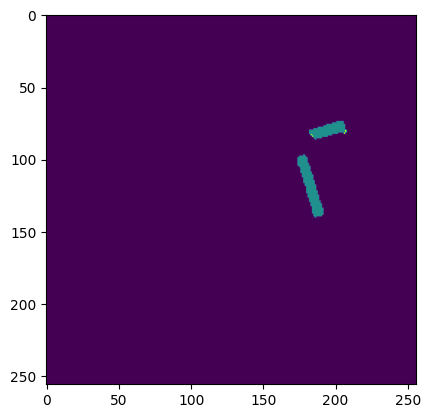

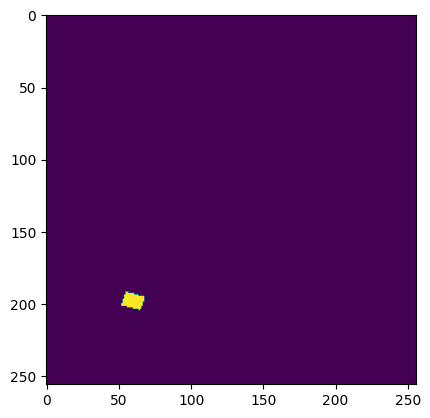

/tmp/ipykernel_19405/4008307092.py:2: RuntimeWarning: invalid value encountered in divide
  norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


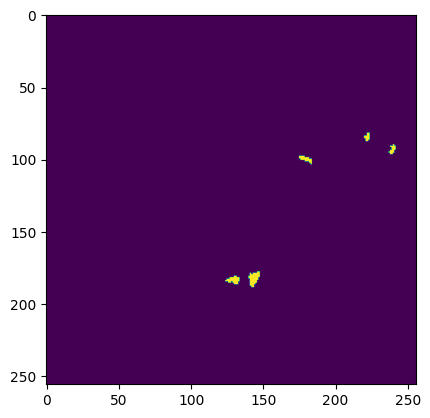

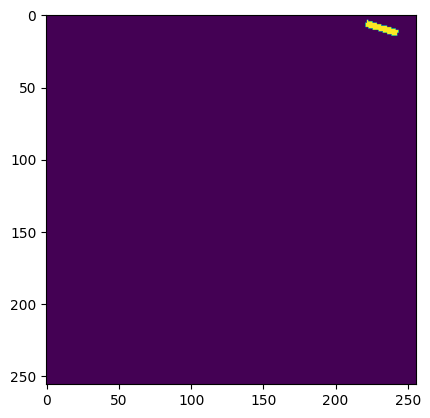

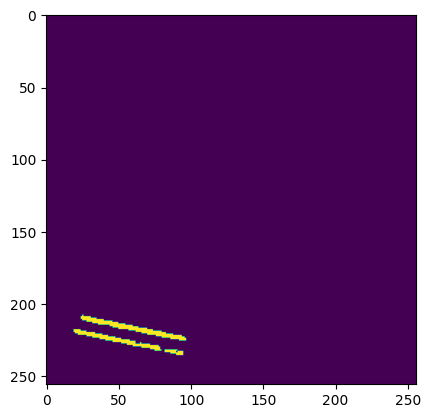

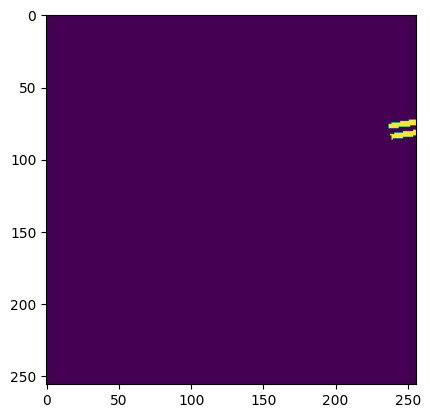

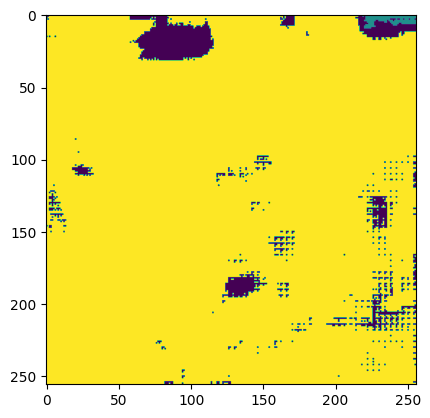

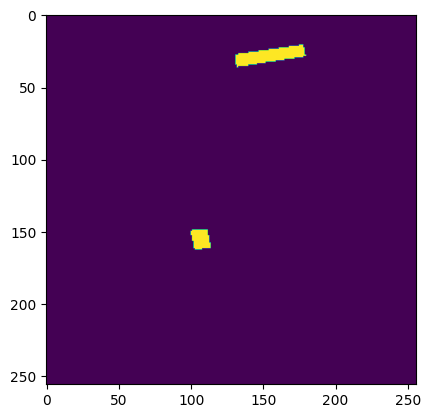

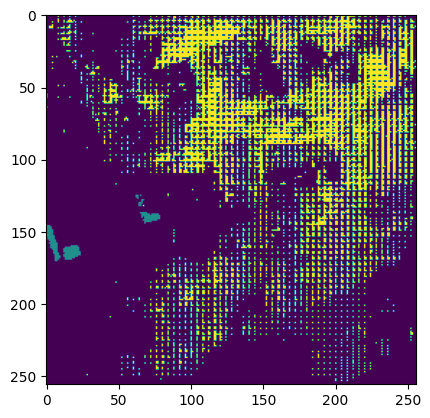

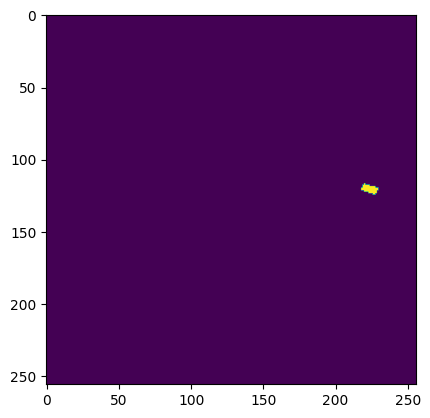

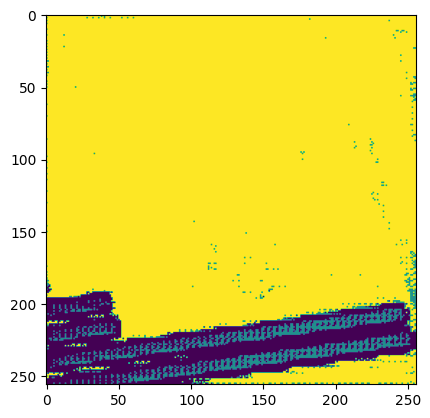

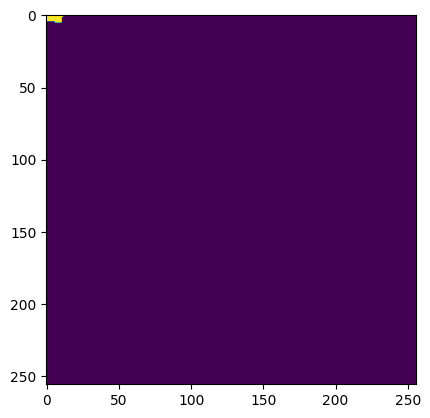

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


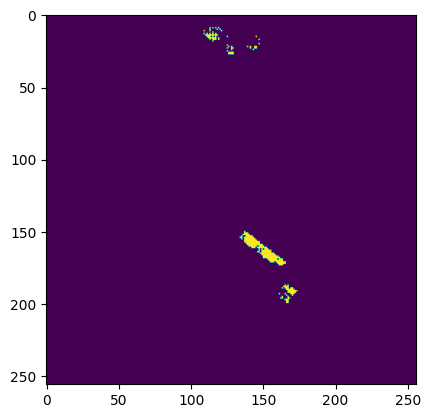

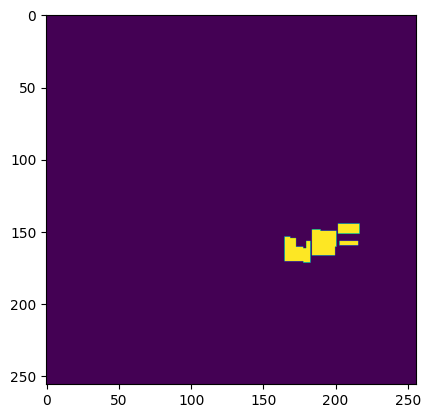

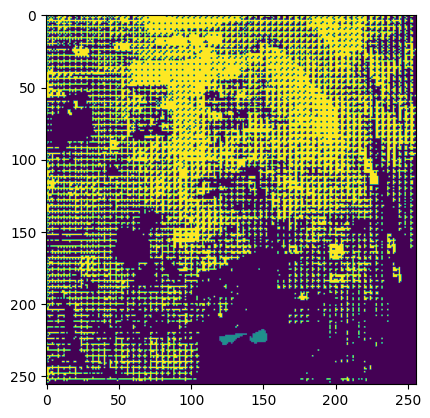

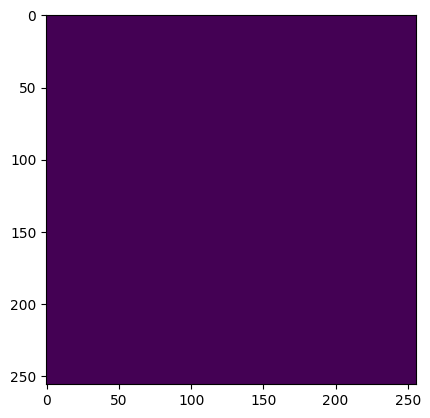

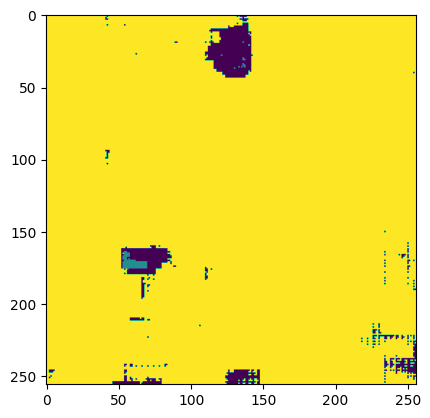

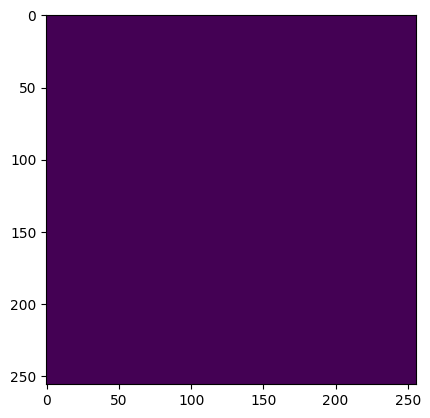

NaN or Inf found in input tensor.


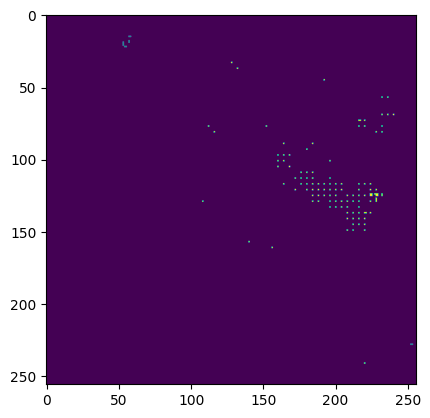

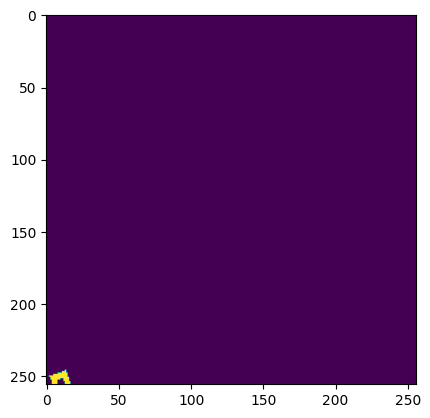

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


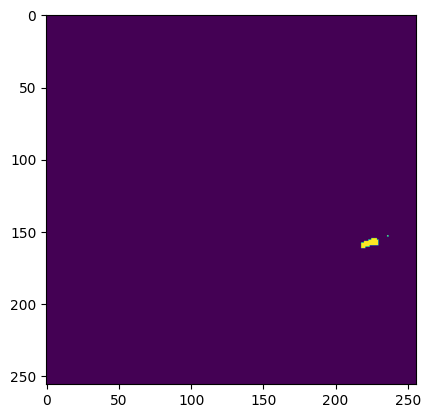

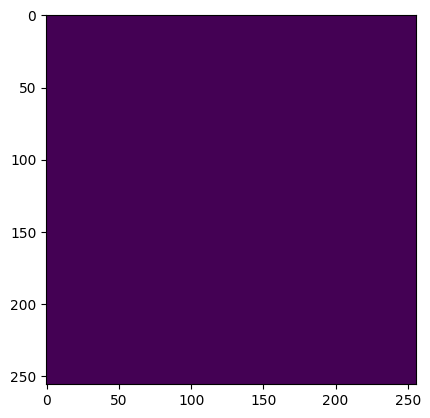

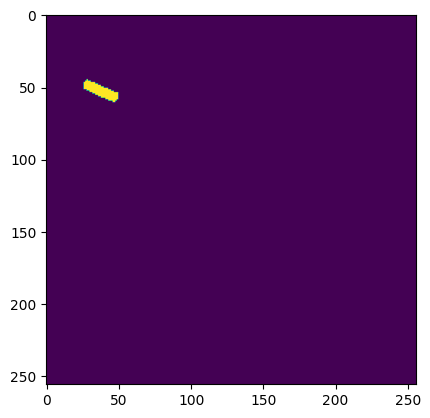

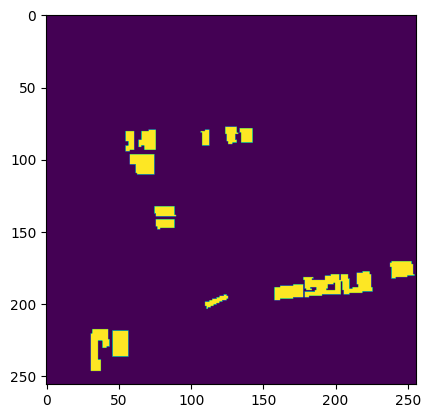

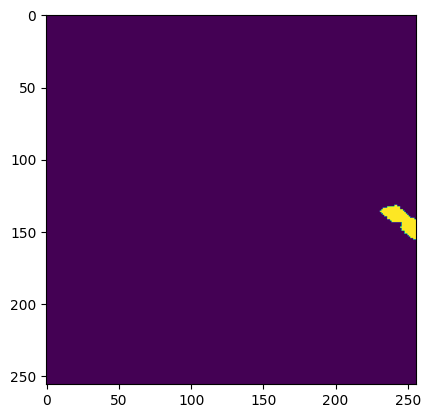

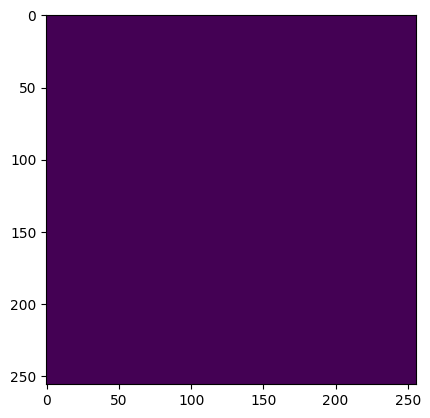

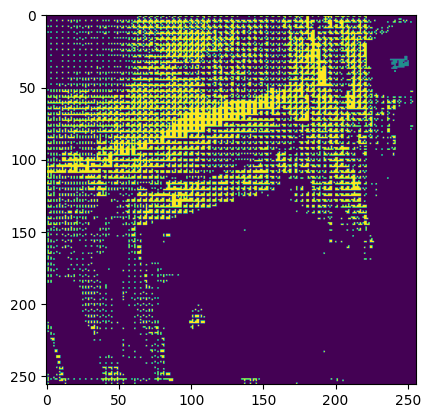

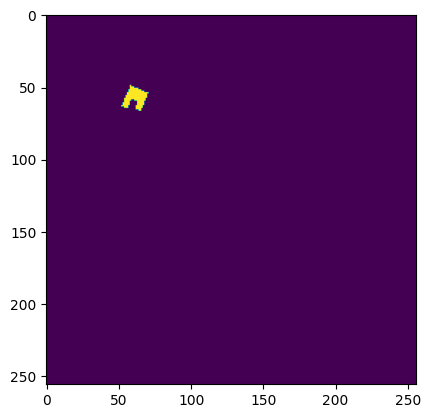

NaN or Inf found in input tensor.


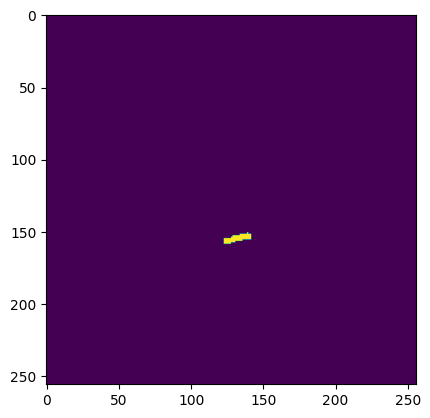

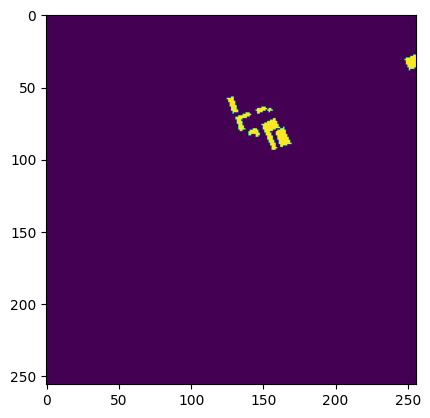

NaN or Inf found in input tensor.


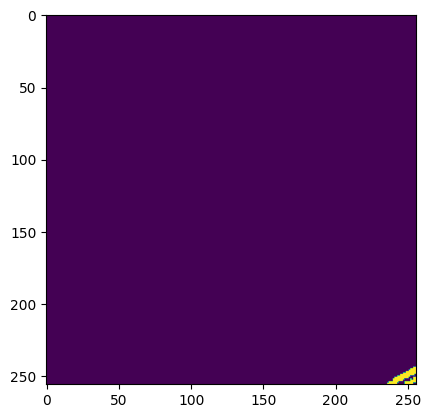

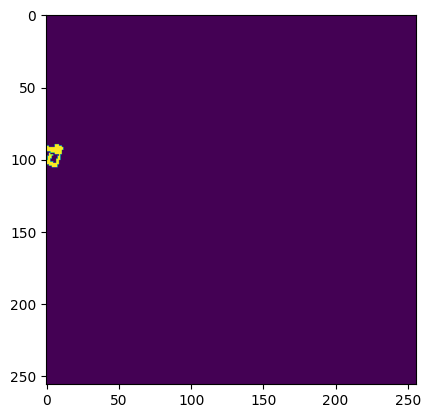

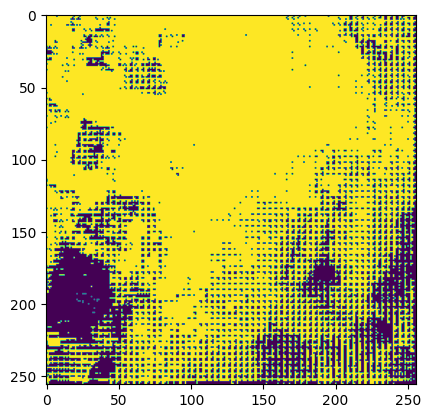

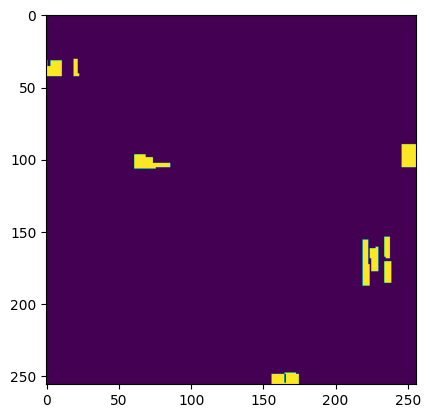

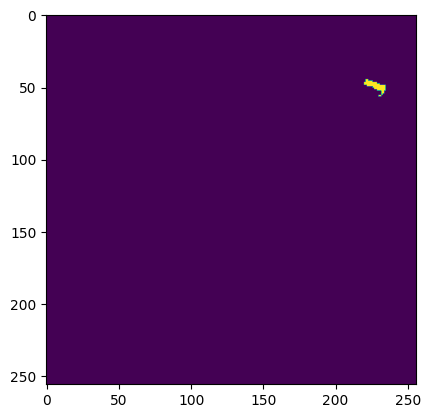

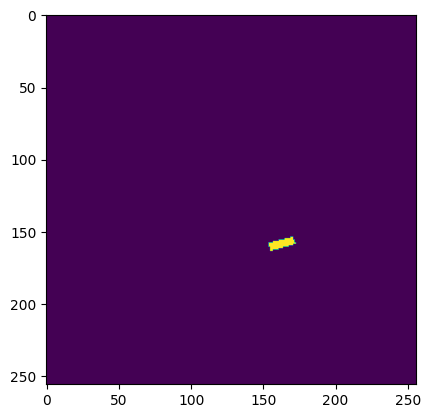

NaN or Inf found in input tensor.


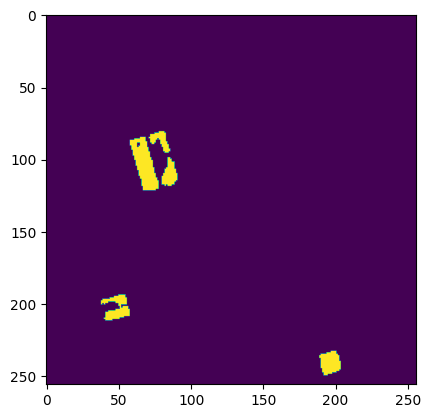

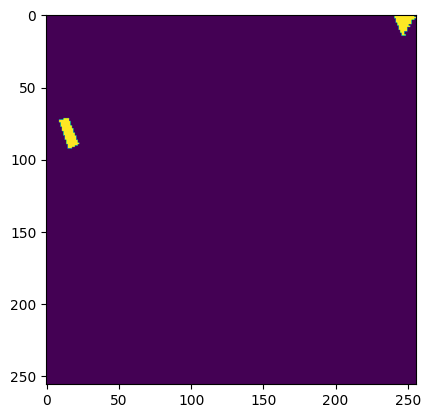

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


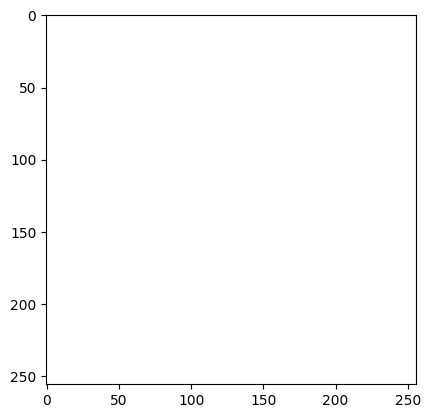

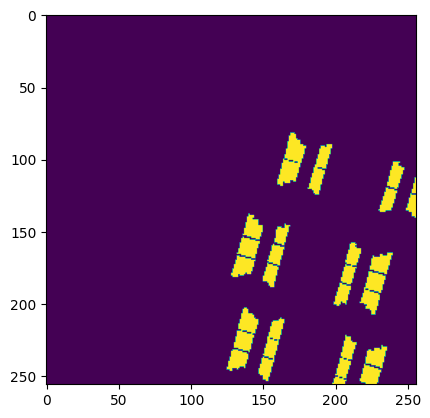

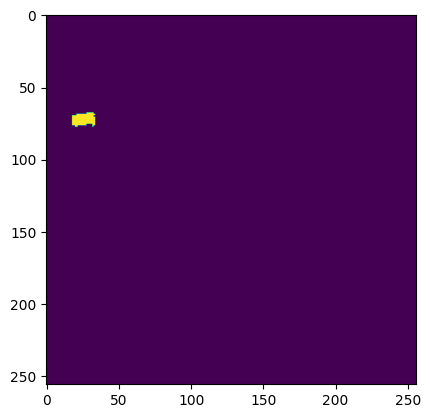

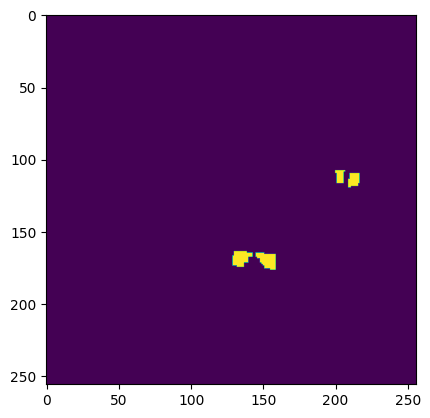

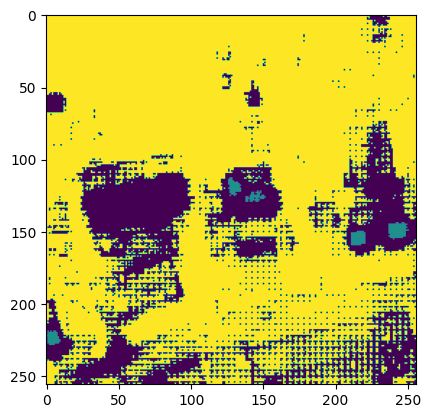

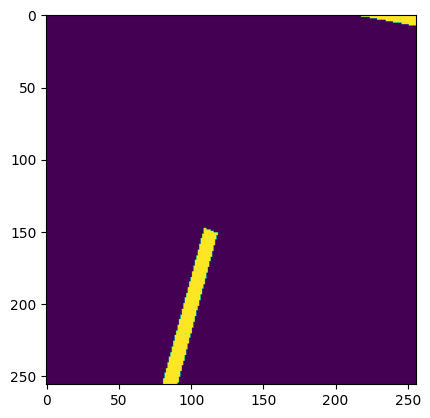

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


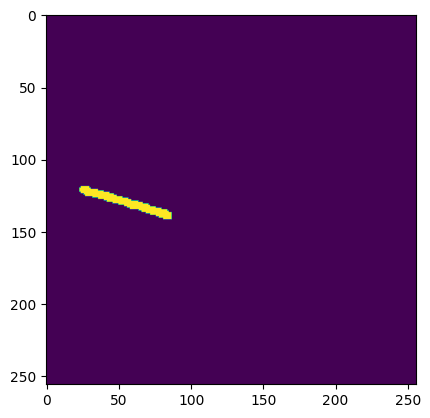

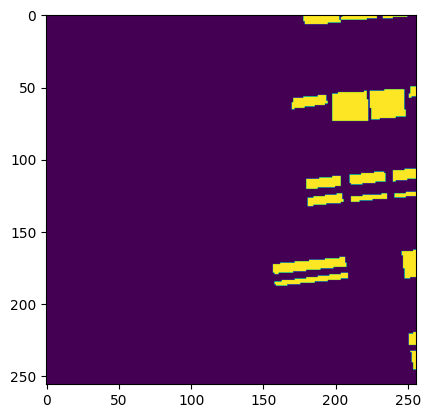

NaN or Inf found in input tensor.


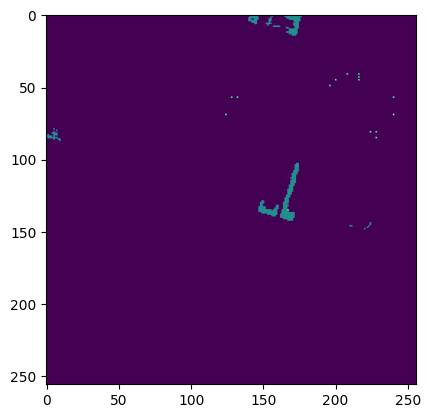

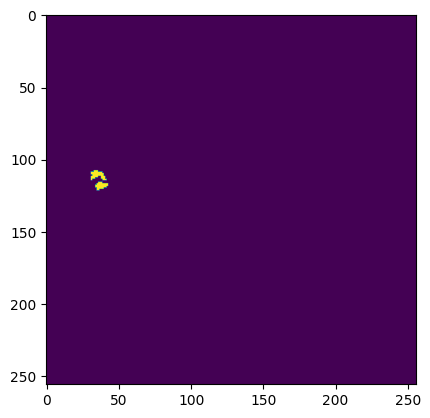

NaN or Inf found in input tensor.


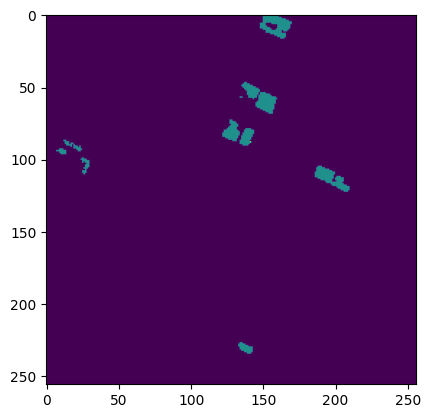

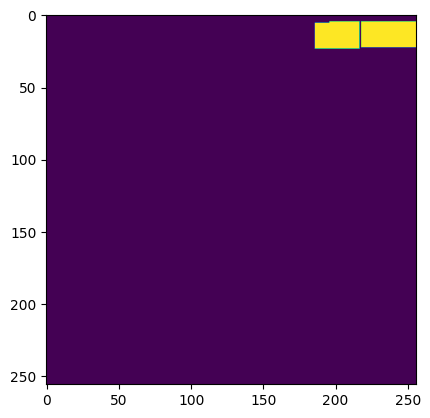

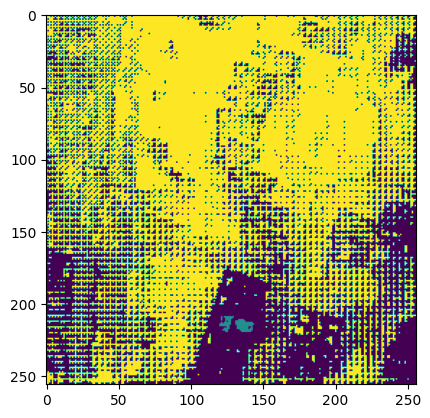

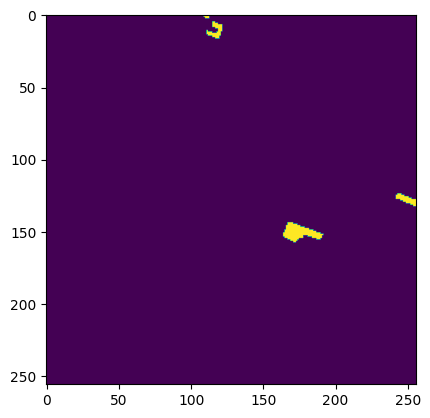

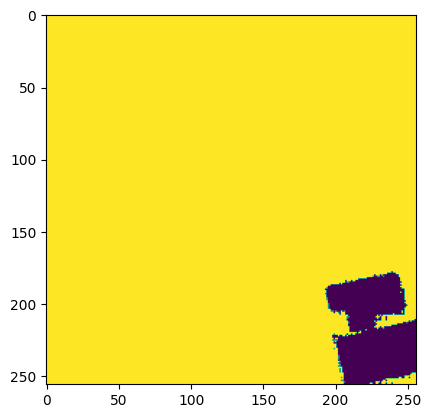

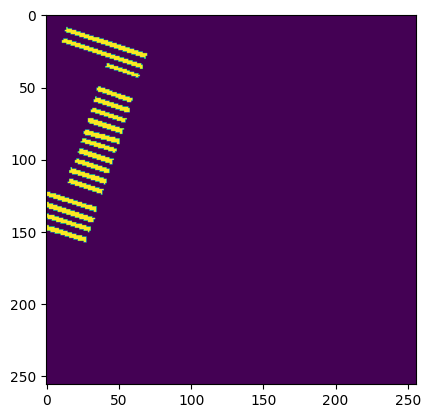

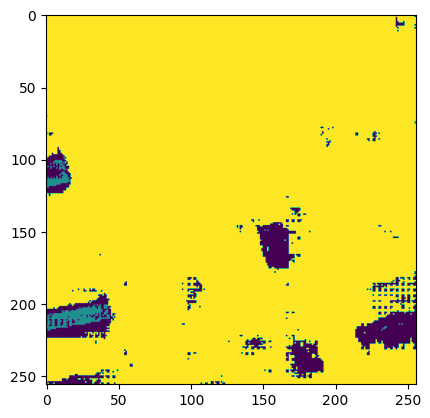

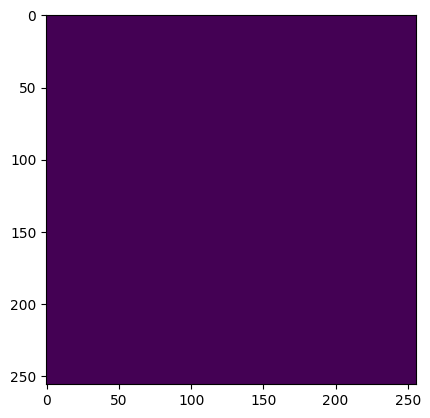

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


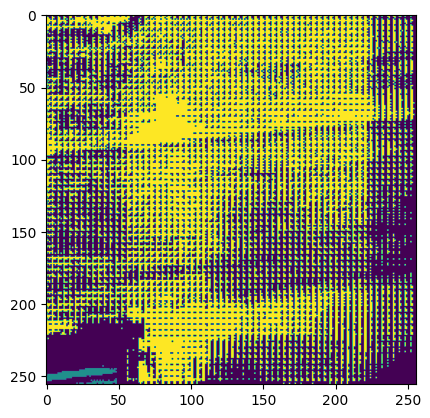

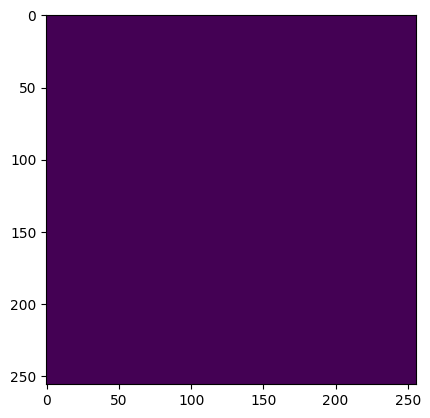

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


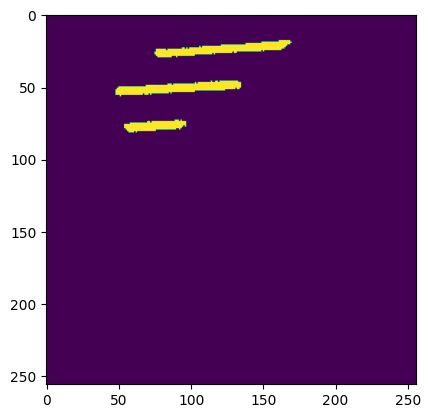

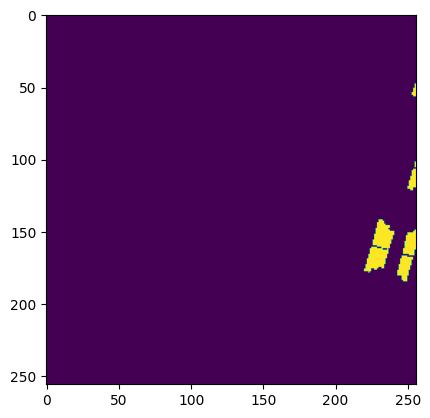

NaN or Inf found in input tensor.


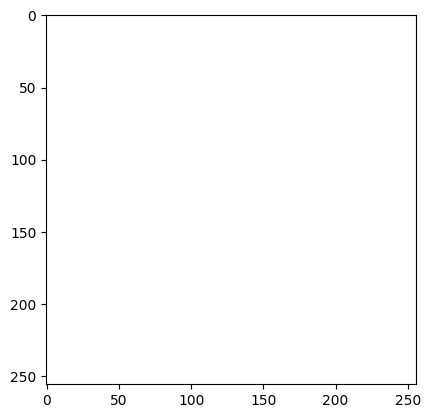

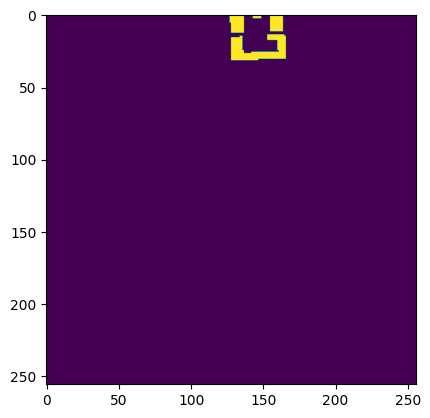

NaN or Inf found in input tensor.


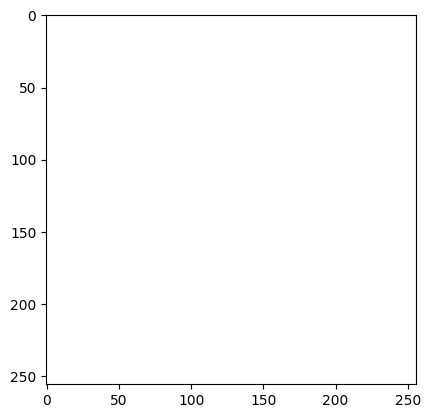

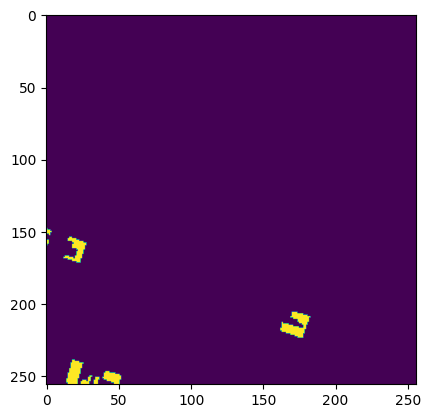

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


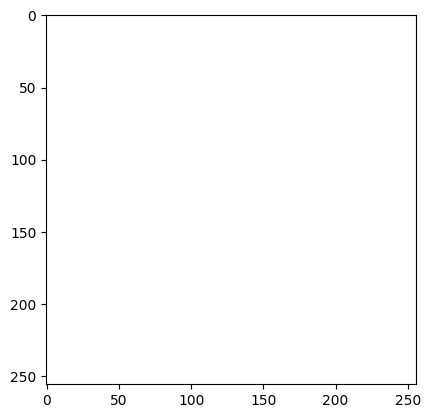

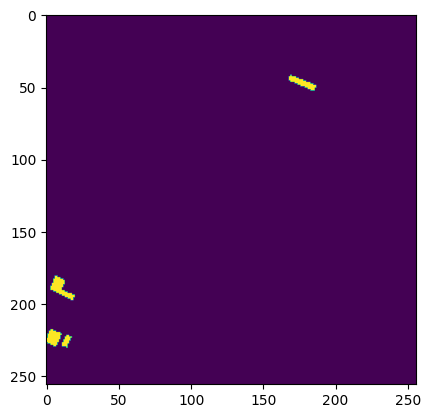

NaN or Inf found in input tensor.


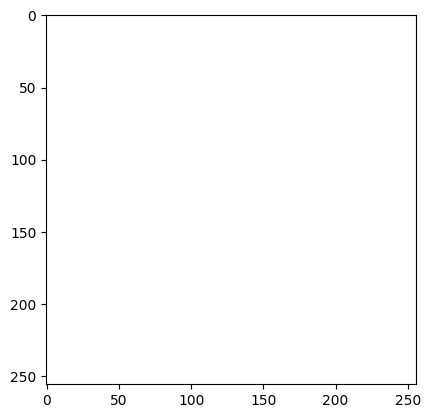

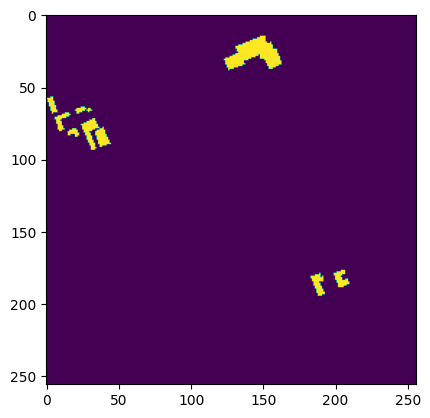

NaN or Inf found in input tensor.


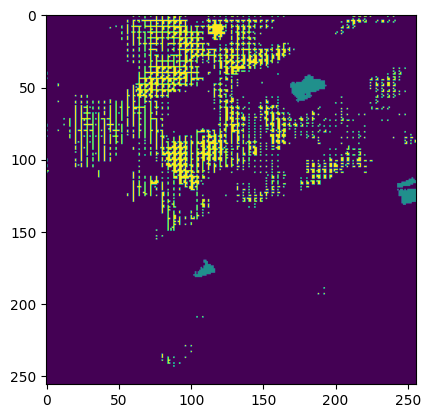

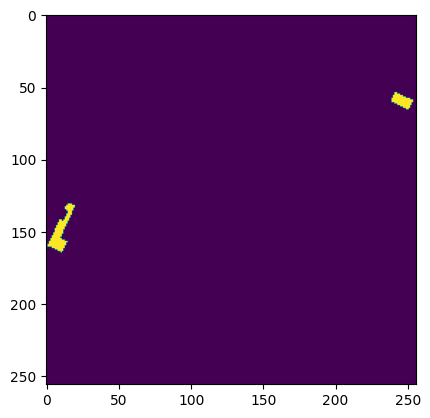

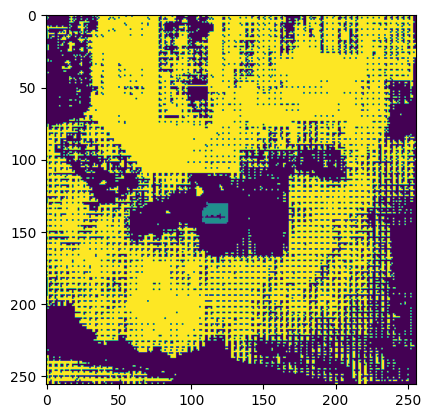

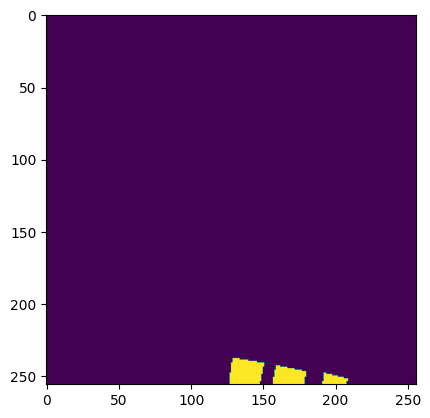

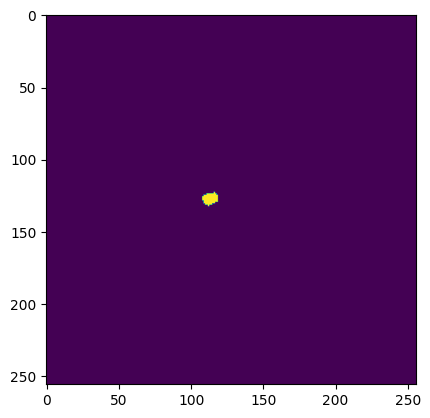

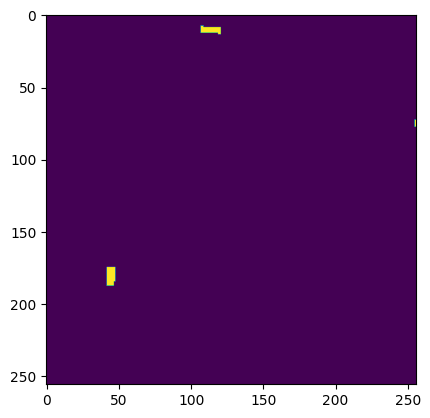

KeyboardInterrupt: 

In [23]:
import metric
import writer

outpath = 'test'

metrics = metric.Metrics(['JaccardIndex', 'DiceCoefficient', 'Precision', 'Recall', 'Accuracy', 'F1Score', 'AUCROC'], device=model.device)
m_writer = writer.Writer(os.path.join(outpath, 'test'))


predict = predictions[1]
predict = predict.squeeze(1)
preds = list(predict)
for i, prediction in enumerate(preds):
  gt_np = train_dataset.__getitem__(i)
  gt_np = gt_np['ground_truth_mask']

  prediction = np.argmax(prediction, axis=0) # convert to single channel (max value)
  prediction = normalize_array(prediction)
  metrics.reset_current()
  pred = torch.from_numpy(prediction)
  gt = torch.from_numpy(gt_np)
  gt = gt.to(model.device)
  pred = pred.to(model.device)
  metrics.update(pred, gt)
  values = metrics.compute()
  
  m_writer.write_metrics_and_means(values, i)
  m_writer.write_pr_curve(prediction,gt, i)
  #m_writer.write_gt_vs_pred_figure(prediction, gt, i, "Gt vs Pred")

  if i%10 == 0:

    plt.imshow(prediction)
    plt.show()

    plt.imshow(gt_np)
    plt.show()